# Acceleration controller

Here, the system is a point body (vehicle) of mass $1$, moving without friction, and controlled by an external force.

The equations of the dynamics are given by

\begin{eqnarray*}
\left(\begin{array}{l}\ddot{x}\\ \ddot{y}\end{array}\right) & = & \gamma(t)
\end{eqnarray*}

$\gamma$ is assumed piecewise constant, with changing points at regular intervals (the control rate). At each changing points, the value of $\gamma$ is acquired from a controller, to which the current state of the system ($x,y,\dot{x},\dot{y}$) is communicated. The controller can thus keep a history of its observations, and base its decisions on it (control loop).

Documentation: [here](../doc/_build/html/odesimu.html)

In [1]:
%pylab nbagg
# for better display performance, use default backend

import logging
logger = logging.getLogger()

from functools import partial
from ipyshow.odesimu.system import System, marker_hook
from ipyshow.odesimu.util import DPiecewiseFunc, buffered, blurred, logger_hook, PIDController

Populating the interactive namespace from numpy and matplotlib


## Vehicle class

In [4]:
#----------------------------------------------------------------------------------------------------
class Vehicle(System):
#----------------------------------------------------------------------------------------------------

    shadowshape = (2,)

    #integrator = dict(name='dopri5')
    # don't use the default intergrator lsoda, as it uses forward looking (not consistent with control)
    integrator = dict(name='dop853')

    def __init__(self,control):
        """
:param control: (lateral) acceleration, in m/s^2
        """
        self.control = control
        def main(t,state):
            x,y,dx,dy = state
            ddx,ddy = control(t)
            return array((dx,dy,ddx,ddy))
        self.main = main
        def fordisplay(state):
            x,y,dx,dy = state
            live = x,y
            return live,live
        self.fordisplay = fordisplay
    
    def runstep(self,crate=None,ini=None,**ka):
        self.control.reset(ini)
        t0 = T = 1/crate
        for t,y in super(Vehicle,self).runstep(ini=ini,**ka):
            if t>t0: self.control.update(t,y); t0 += T
            yield t,y

    def display(self,ax,bounds=None,**ka):
        ax.scatter((0,),(0,),c='k',marker='o')
        diag_s = ax.scatter((),(),c='b',marker='o',label='vehicle')
        tail_l, = ax.plot((),(),'y')
        ax.set_title(r'Vehicle under acceleration control')
        ax.set_xlim(bounds[0][0],bounds[1][0])
        ax.set_ylim(bounds[0][1],bounds[1][1])
        def disp(t,live,tail):
            diag_s.set_offsets((live,))
            tail_l.set_data(tail[:,0],tail[:,1])
        anim = super(Vehicle,self).display(ax,disp,**ka)
        ax.legend(fontsize='x-small')
        return anim

    @staticmethod
    def makestate(x=0.,y=0.,dx=0.,dy=0.): return array((x,y,dx,dy))

    launchdefaults = dict(maxtime=infty,srate=25.,taild=10,hooks=(partial(logger_hook,logger=logger),),animate=dict(repeat=False,))
    def launch(self,**ka):
        for k,v in self.launchdefaults.items(): ka.setdefault(k,v)
        return super().launch(**ka)

Launcher
========

System parameters:

* `control`: control force exerted on vehicle, as a function mapping time (in sec) to force (in N)

Here, the control force is defined by a controller which attemps to force the vehicle to track a target through a feedback loop. The target is defined by a function mapping time to a position in the plane.

PID controller parameters:

* `gP,gI,gD`: proportional, integration and derivative gains
* `target`: target function, input: time, output: perceived target value (here the perceived position of the target in the plane)
* `observe`: feedback observation function, input: real system state, output: perceived system state (here the perceived position of the vehicle in the plane)

Launch parameters:

* `ini/x,y,dx,dy`: initial position and speed of the vehicle (in m and m.sec$^{-1}$)
* `srate`: simulation rate (in sec$^{-1}$), also taken to be the display rate
* `taild`: duration of the shadow, ie. the trace of previous states (in sec)
* `bounds`: pair of coordinates (in m) of the opposite corners (lower left and upper right) of the display boundaries
* `hooks`: list of display hooks (see doc)
* `crate`: control rate, at which the controller is notified of the current state of the vehicle (in sec$^{-1}$)

<IPython.core.display.Javascript object>


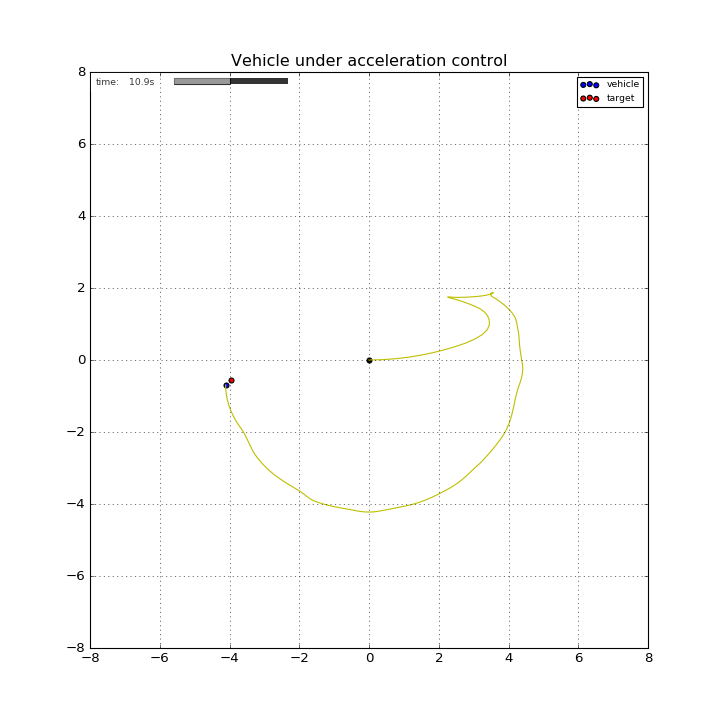

In [5]:
logger.setLevel(logging.WARNING) # can be changed dynamically by logger_hook

period = 15
def target_still(t,spot=array((7.,5.))): return spot
def target_circle(t,R=4.,omega=2*pi/period):
    p = omega*t
    return R*hstack((sin(p),cos(p)))
def target_cycloid(t,R=4.,r=2.,l=-5.,omega=2*pi/period):
    p = omega*t
    return hstack((
        R*sin(p)+r*sin(l*p),
        R*cos(p)+r*cos(l*p),
        ))

#target = target_still
target = buffered(T=period,N=int(period*100))(target_circle)
#target = buffered(T=period,N=int(period*100))(partial(target_cycloid,l=5))

control = PIDController(
      N=2,
      gP=3.,
      #gP=.5,
      #gI=1.,
      gD=5.,
      #gD=7.,
      target=blurred(0.01,shape=(2,))(target),
      observe=(lambda state=zeros((4,)):state[:2]),
      )

syst = Vehicle(control)
syst.launch(
    ini=syst.makestate(x=0.,y=0.,dx=10.,dy=0.),
    crate=5.,
    bounds=((-8.,-8.),(8.,8.)),
    hooks=(partial(marker_hook,f=target,marker='o',s=20,label='target'),partial(logger_hook,logger=logger)),
    taild=period+5.,
)